In [1]:
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt

import cupy as cp
import cufinufft
import finufft

import ducc0

import pysht
from pysht import get_geom

from lenspyx import cachers

import delensalot
from delensalot import utils
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs

mode = 'nuFFT'


def get_toydata(lmax=1024, mmax=1024, geominfo=('gl',{'lmax': 1024})):
    ll = np.arange(0,lmax)
    # geominfo = ('gl',{'lmax': lmax})
    # geominfo = ('healpix',{'nside': 512})

    synunl = Xunl(lmax=lmax, geominfo=geominfo)
    synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo)

    philm = synunl.get_sim_phi(0, space='alm')
    dlm = hp.almxfl(philm, np.sqrt(ll*(ll+1)))

    Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
    # Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')

    return Tunl, dlm, philm
# int(t.geom.nph[0]/2-1)

def synth_gen(Tunl, solver, dlm, lmax):
    if solver in ['finufft']:
        defres, ptg, map_dfs = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
        print("defres.shape: {}".format(defres.shape))
    elif solver in ['duccnufft']:
        defres, ptg, map_dfs = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
        print("defres.shape: {}".format(defres.shape))
    elif solver == 'ducc':
        defres = t.synthesis_general(Tunl.copy(), dlm=dlm, mmax=lmax, spin=0, backwards=False)
        print("defres.shape: {}".format(defres.shape))
    elif solver == 'cufinufft':
        defres, ptg, map_dfs = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
        print("defres.shape: {}".format(defres.shape))
    return defres, ptg, map_dfs

[SHTns 3.6.1] built Feb 15 2024, 12:12:28, id: v3.6.1-41-g3d56397*,avx2,ishioka,openmp
mpisupport: True, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [ ]:
solver = 'cufinufft'
backend = 'GPU'
t = pysht.get_transformer(solver, mode, backend)

# lmax = 2048
# mmax = 2048
# geominfo = ('gl',{'lmax': lmax})
# t.set_geometry(geominfo)
# Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
# defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)

bm_GPU = []
for lmax in 256*np.arange(1,16):
    mmax = lmax
    geominfo = ('gl',{'lmax': lmax})
    t.set_geometry(geominfo)

    Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
    defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)
    del t.cacher
    t.cacher = cachers.cacher_mem()
    x = cp.array(ptg[:,1])
    y = cp.array(ptg[:,0])
    data = cp.array(map_dfs.astype(np.complex128))
    result = %timeit -n 1 -r 1 -o cufinufft.nufft2d2(x=x, y=y, data=data, eps=1e-10)
    bm_GPU.append([lmax, result])
    

In [ ]:
solver = 'finufft'
backend = 'CPU'
t = pysht.get_transformer(solver, mode, backend)

# lmax = 2048
# mmax = 2048
# geominfo = ('gl',{'lmax': lmax})
# t.set_geometry(geominfo)
# Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
# defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)
if 'defres' in locals():
    defres = np.array(defres)
    ptg = np.array(ptg)
    map_dfs = np.array(map_dfs)


bm_CPU = []
for lmax in 256*np.arange(1,16):
    mmax = lmax
    geominfo = ('gl',{'lmax': lmax})
    t.set_geometry(geominfo)

    Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
    defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)
    del t.cacher
    t.cacher = cachers.cacher_mem()
    result = %timeit -r 1 -n 1 -o finufft.nufft2d2(x=ptg[:,0], y=ptg[:,1], f=map_dfs.astype(np.complex128), eps=1e-10)
    bm_CPU.append([lmax, result])

In [9]:
solver = 'duccnufft'
backend = 'CPU'
t = pysht.get_transformer(solver, mode, backend)

# lmax = 2048
# mmax = 2048
# geominfo = ('gl',{'lmax': lmax})
# t.set_geometry(geominfo)
# Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
# defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)

bm_CPU_ducc = []
for lmax in 256*np.arange(1,16):
    mmax = lmax
    geominfo = ('gl',{'lmax': lmax})
    t.set_geometry(geominfo)

    Tunl, dlm, philm = get_toydata(lmax, mmax, geominfo)
    defres, ptg, map_dfs = synth_gen(Tunl, solver, dlm, lmax)
    del t.cacher
    t.cacher = cachers.cacher_mem()
    result = %timeit -n 1 -r 1 -o values = ducc0.nufft.u2nu(grid=map_dfs, coord=ptg, forward=True, epsilon=1e-10, nthreads=4, verbosity=1, periodicity=2 * np.pi, fft_order=True)
    bm_CPU_ducc.append([lmax, result])
    

build angles <- synthesis (GRAD_ONLY)
build_angles
U2nu:
  nthreads=1, grid=(6718x6720), oversampled grid=(10500x10500), supp=10, eps=1.000000000000000e-07
  npoints=22470750
  memory overhead: 8.371006697416306e-02GB (index) + 1.642853021621704e+00GB (oversampled grid)
defres.shape: (22470750,)

Total wall clock time for u2nu: 7.282s
|
+- u2nu proper          : 91.74% (6.6802s)
|  |
|  +- FFT                  : 48.22% (3.2213s)
|  +- interpolation        : 44.27% (2.9574s)
|  +- zeroing grid         :  5.08% (0.3393s)
|  +- grid correction      :  2.43% (0.1623s)
|  +- allocating grid      :  0.00% (0.0000s)
|  
+- building index       :  8.23% (0.5996s)
+- correction factors   :  0.02% (0.0012s)
+- parameter calculation:  0.00% (0.0000s)
U2nu:
  nthreads=1, grid=(6718x6720), oversampled grid=(10080x10164), supp=14, eps=1.000000000000000e-10
  npoints=22470750
  memory overhead: 8.371006697416306e-02GB (index) + 1.526670455932617e+00GB (oversampled grid)
8.76 s ± 0 ns per loop (mean ±

Text(0.5, 1.0, 'nuFFT2d2 time for different lmax')


Total wall clock time for u2nu: 11.68s
|
+- u2nu proper          : 93.28% (10.8938s)
|  |
|  +- interpolation        : 55.22% ( 6.0150s)
|  +- FFT                  : 39.05% ( 4.2541s)
|  +- zeroing grid         :  3.75% ( 0.4089s)
|  +- grid correction      :  1.98% ( 0.2158s)
|  +- allocating grid      :  0.00% ( 0.0000s)
|  
+- building index       :  6.70% ( 0.7821s)
+- correction factors   :  0.02% ( 0.0019s)
+- parameter calculation:  0.00% ( 0.0000s)


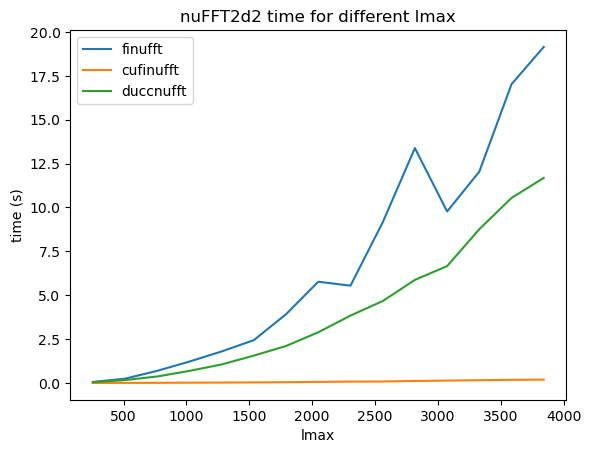

In [10]:
plt.plot([bC[0] for bC in bm_CPU], [bC[1].average for bC in bm_CPU], label='finufft')
plt.plot([bG[0] for bG in bm_GPU], [bG[1].average for bG in bm_GPU], label='cufinufft')
plt.plot([bC[0] for bC in bm_CPU_ducc], [bC[1].average for bC in bm_CPU_ducc], label='duccnufft')
plt.legend()
plt.ylabel('time (s)')
plt.xlabel('lmax')
plt.title('nuFFT2d2 time for different lmax')

Text(0.5, 1.0, 'speedup')

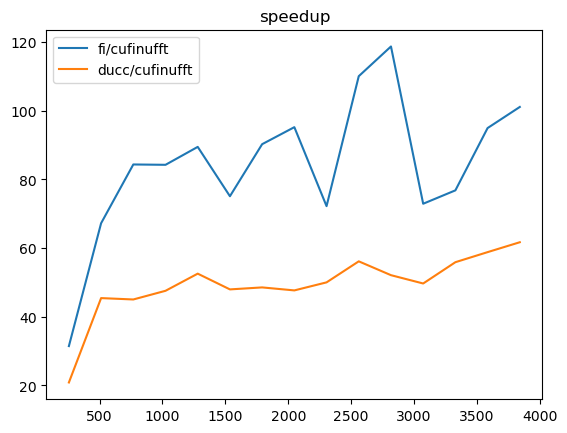

In [11]:
plt.plot([bC[0] for bC in bm_CPU], [bC[1].average/bG[1].average for bC, bG in zip(bm_CPU, bm_GPU)], label='fi/cufinufft')
plt.plot([bC[0] for bC in bm_CPU], [bC[1].average/bG[1].average for bC, bG in zip(bm_CPU_ducc, bm_GPU)], label='ducc/cufinufft')
plt.legend()
# plt.plot([bG[0] for bG in bm_GPU], [bG[1].average for bG in bm_GPU], label='cufinufft')
# plt.plot([bC[0] for bC in bm_CPU_ducc], [bC[1].average for bC in bm_CPU_ducc], label='duccnufft')
plt.title('speedup')

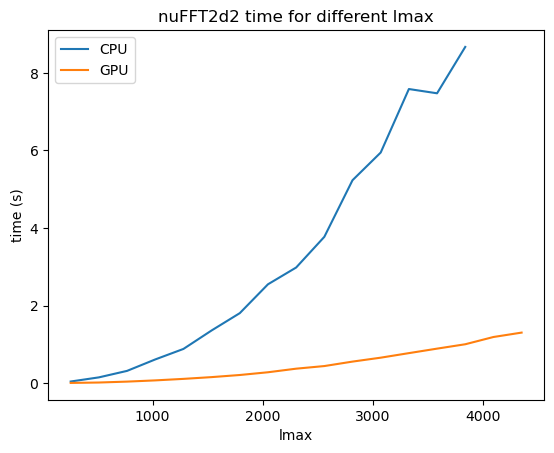